# BUILD WEEK

Dakota Porter 16 NOV 2020

- This notebook contains a full machine learning workflow predicting the Manufacturer Suggested Retail Prices (MSRP) of just over 11,000 cars

# Import Data and Packages

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.inspection import permutation_importance, plot_partial_dependence

In [3]:
## Import data from /data folder

df_raw = pd.read_csv('../data/msrp.csv')

# Exploratory Data Analysis

- Explore distribution and types of data in this DataFrame
- Look at target variable distribution
- Search for outliers or possible points of data leakage
- Look for features that may or may not be correlated with target variable
- Inspect categorical columns

In [4]:
## Let's see what we are working with

df_raw.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
## Check out data distribution

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

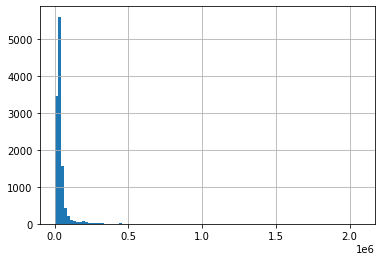

In [6]:
## 'MSRP' is a regression target
## Let's look at its distribution

df_raw['MSRP'].hist(bins=100);

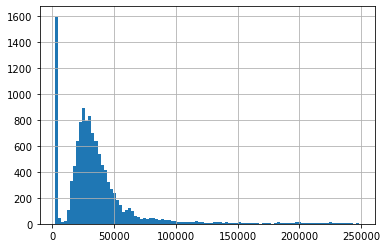

In [7]:
## Closer target inspection; clearly some outliers

mask = df_raw['MSRP'] < 250000
df_raw[mask]['MSRP'].hist(bins=100);

In [8]:
## 'Make' can be a classification target
## Let's see its distribution as well

df_raw['Make'].value_counts()

Chevrolet        1123
Ford              881
Volkswagen        809
Toyota            746
Dodge             626
Nissan            558
GMC               515
Honda             449
Mazda             423
Cadillac          397
Mercedes-Benz     353
Suzuki            351
BMW               334
Infiniti          330
Audi              328
Hyundai           303
Volvo             281
Subaru            256
Acura             252
Kia               231
Mitsubishi        213
Lexus             202
Buick             196
Chrysler          187
Pontiac           186
Lincoln           164
Oldsmobile        150
Land Rover        143
Porsche           136
Saab              111
Aston Martin       93
Plymouth           82
Bentley            74
Ferrari            69
FIAT               62
Scion              60
Maserati           58
Lamborghini        52
Rolls-Royce        31
Lotus              29
Tesla              18
HUMMER             17
Maybach            16
Alfa Romeo          5
McLaren             5
Spyker    

In [9]:
## Not sure what 'Popularity' is; closer look

df_raw['Popularity'].value_counts() ## Counts exaclty match 'Make' distribution

1385    1123
5657     881
873      809
2031     746
1851     626
2009     558
549      515
2202     449
586      423
1624     397
617      353
481      351
3916     334
190      330
3105     328
1439     303
870      281
640      256
204      252
1720     231
436      213
454      202
155      196
1013     187
210      186
61       164
26       150
258      143
1715     136
376      111
259       93
535       82
520       74
2774      69
819       62
105       60
238       58
1158      52
86        31
613       29
1391      18
130       17
67        16
416        5
113        5
21         3
820        3
2          3
Name: Popularity, dtype: int64

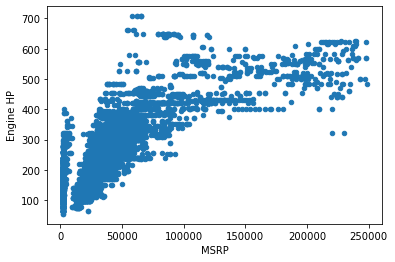

In [10]:
## Look for feature correlation (using above mask)

df_raw[mask].plot.scatter('MSRP', 'Engine HP');

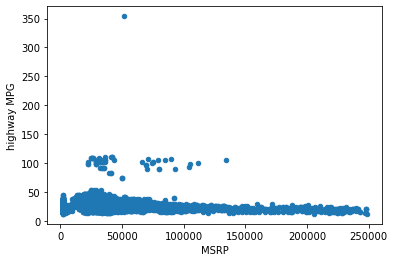

In [11]:
## Another feature

df_raw[mask].plot.scatter('MSRP', 'highway MPG'); ## Clearly no correlation

In [12]:
## Categorical column info

df_raw.select_dtypes('object').nunique().sort_values()

Vehicle Size           3
Driven_Wheels          4
Transmission Type      5
Engine Fuel Type      10
Vehicle Style         16
Make                  48
Market Category       71
Model                915
dtype: int64

In [13]:
## 'Model' looks to be a culprit of leakage
## Not so much for regression but would be very guilty for classification

df_raw['Model'].value_counts()

Silverado 1500           156
Tundra                   140
F-150                    126
Sierra 1500               90
Beetle Convertible        89
                        ... 
RS 6                       1
Sigma                      1
Accord Plug-In Hybrid      1
LFA                        1
650S Spider                1
Name: Model, Length: 915, dtype: int64

## Feature Engineering

In [14]:
## 'Market Category' can be reduced, encoded and used in a different way

df_raw['Market Category'].value_counts()

Crossover                                          1110
Flex Fuel                                           872
Luxury                                              855
Luxury,Performance                                  673
Hatchback                                           641
                                                   ... 
Crossover,Exotic,Luxury,High-Performance              1
Exotic,Luxury,High-Performance,Hybrid                 1
Performance,Hybrid                                    1
Crossover,Exotic,Luxury,Performance                   1
Flex Fuel,Factory Tuner,Luxury,High-Performance       1
Name: Market Category, Length: 71, dtype: int64

In [15]:
## Difference in highway and city mpg

df_raw['lost_mpg'] = df_raw['highway MPG'] - df_raw['city mpg']

# Wrangle Data

- Pass raw DataFrame through below wrangle function for the new, cleaned dataset

In [16]:
def wrangle(df):
    
    ## Create a copy to preserve raw data
    df = df.copy()
    
    ## Fix column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    ## Remove Outliers
    df = df[df['msrp'] <= 75000]
    
    ## Reduce high cardinality in 'make'
    df['make'] = [x if x in list(df['make'].value_counts().sort_values().tail(5).index) else 'Other' for x in df['make']]
    
    ## Reduce high cardinality in 'market_category' (maybe remove NaN's)
    df['luxury'] = [1 if 'Luxury' in x else 0 for x in df['market_category'].fillna('X')]
    
    ## 'Model' is going to allow for leakage in a way
    ## Remove 'market_category' due to addition of 'luxury'
    df.drop(columns=['model', 'market_category'], inplace=True)
    
    ## Lower all text case for easier readability and manipulation
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.lower()
    
    return df

In [17]:
## Show this data who's boss

df = wrangle(df_raw)

In [18]:
## Check it out

df.head()

,make,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,lost_mpg,luxury
0,other,2011,premium unleaded (required),335.0,6.0,manual,rear wheel drive,2.0,compact,coupe,26,19,3916,46135,7,1
1,other,2011,premium unleaded (required),300.0,6.0,manual,rear wheel drive,2.0,compact,convertible,28,19,3916,40650,9,1
2,other,2011,premium unleaded (required),300.0,6.0,manual,rear wheel drive,2.0,compact,coupe,28,20,3916,36350,8,1
3,other,2011,premium unleaded (required),230.0,6.0,manual,rear wheel drive,2.0,compact,coupe,28,18,3916,29450,10,1
4,other,2011,premium unleaded (required),230.0,6.0,manual,rear wheel drive,2.0,compact,convertible,28,18,3916,34500,10,1


# Split Data

- Target Vector: 'msrp'
- Feature Matrix: everything else
- We will use an 80/20 train-test split

In [19]:
## Split data into target vector and feature matrix

target = 'msrp'
y = df[target]
X = df.drop(columns=target)

In [20]:
## Split data 80/20 and set a random state to get same results

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
## Assert that splits were made properly

assert y.shape == (len(y),)
assert len(X_train) + len(X_test) == len(X)
assert len(y_train) + len(y_test) == len(y)

# Establish Baseline

- How far off will our model be if it could only predict the average price?

In [22]:
y_base = [y.mean()] * len(y)
print(f'Baseline MAE: ${mean_absolute_error(y, y_base)}')

Baseline MAE: $12425.352918853203


# Build Models

- According to target variable, we require regression for our task
- We will use both Linear Regression and a boost regression model to optimize our goal
- We will require transformers such as: Ordinal Encoder (for categorical columns), Imputer (to impute missing values), and a Scaler (to regularize our coefficients)

In [23]:
## Build our first model pipeline using the required predictor and transformers
## Then fit out model to the training data

lr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

lr.fit(X_train, y_train);

In [24]:
## Build our second model pipeline and fit to training data

gbr = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    GradientBoostingRegressor(loss='ls',
                             n_estimators=235,
                             subsample=0.7,
                             max_depth=6,
                             random_state=42)
)

gbr.fit(X_train, y_train);

In [25]:
## Build third model pipeline and fit to training data

xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBRegressor(subsample=0.6,
                max_depth=7)
)

xgb.fit(X_train, y_train);

[23:57:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# Check Metrics

- The best metrics to evaluate these models will be mean absolute error and $R^2$
- Mean absolute error will tell us generally how far off we are in our predictions
- $R^2$ will tell us how much of the variance in the data is explained by our model

In [26]:
print(f'LR Training MAE: ${mean_absolute_error(y_train, lr.predict(X_train))}')
print(f'LR Test MAE: ${mean_absolute_error(y_test, lr.predict(X_test))}')
print(f'\nLR Training R^2: {round(r2_score(y_train, lr.predict(X_train))*100, 2)}%')
print(f'LR Test R^2: {round(r2_score(y_test, lr.predict(X_test))*100, 2)}%')

LR Training MAE: $5457.355691281245
LR Test MAE: $5478.495571707722

LR Training R^2: 79.93%
LR Test R^2: 79.56%


In [27]:
## With default params:
## test mae = 3161
## test r2 = 92.12

## With loss='ls' & n_estimators=235 & subsample=0.7 & max_depth=5
## test mae = 2177
## test r2 = 95.99

In [28]:
print(f'Boost Training MAE: ${mean_absolute_error(y_train, gbr.predict(X_train))}')
print(f'Boost Test MAE: ${mean_absolute_error(y_test, gbr.predict(X_test))}')
print(f'\nBoost Training R^2: {round(r2_score(y_train, gbr.predict(X_train))*100, 2)}%')
print(f'Boost Test R^2: {round(r2_score(y_test, gbr.predict(X_test))*100, 2)}%')

Boost Training MAE: $1627.9903178665122
Boost Test MAE: $2177.2528580859425

Boost Training R^2: 97.96%
Boost Test R^2: 95.99%


In [29]:
## With default params:
## test mae = 3183
## test r2 = 92.02

## With subsample=0.6 & max_depth=7
## test mae = 2244
## test r2 = 95.88

In [30]:
print(f'XGBoost Training MAE: ${mean_absolute_error(y_train, xgb.predict(X_train))}')
print(f'XGBoost Test MAE: ${mean_absolute_error(y_test, xgb.predict(X_test))}')
print(f'\nXGBoost Training R^2: {round(r2_score(y_train, xgb.predict(X_train))*100, 2)}%')
print(f'XGBoost Test R^2: {round(r2_score(y_test, xgb.predict(X_test))*100, 2)}%')

XGBoost Training MAE: $1753.0993710080652
XGBoost Test MAE: $2244.5278909752064

XGBoost Training R^2: 97.63%
XGBoost Test R^2: 95.88%


# Hyperparameter Tuning

- Our Gradient Boosting Regressor seems to be our best model
- We can still try to improve it however

In [31]:
## Choose the hyperparameters in which we want to test for GBR

param_grid = {
    'gradientboostingregressor__n_estimators': range(225, 251, 5),
    'gradientboostingregressor__subsample': np.arange(0.4, 0.8, 0.1),
    'gradientboostingregressor__max_depth': range(5, 10)
}

## Conduct a RandomizedSearchCV

gbr_rs = RandomizedSearchCV(
    gbr,
    param_grid,
    n_iter=10,
    n_jobs=3,
    random_state=42
)

gbr_rs.fit(X_train, y_train);

## Retrieve best parameters
gbr_rs.best_params_

C:\Users\dakot\anaconda3\envs\unit2\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


{'gradientboostingregressor__subsample': 0.6,
 'gradientboostingregressor__n_estimators': 225,
 'gradientboostingregressor__max_depth': 6}

In [32]:
## Choose the hyperparameters in which we want to test for XGB

param_grid = {
    'xgbregressor__subsample': np.arange(0.4, 0.8, 0.1),
    'xgbregressor__max_depth': range(4, 8)
}

## Conduct a RandomizedSearchCV

xgb_rs = RandomizedSearchCV(
    xgb,
    param_grid,
    n_iter=10,
    n_jobs=3,
    random_state=42
)

xgb_rs.fit(X_train, y_train);

## Retrieve best parameters
xgb_rs.best_params_

C:\Users\dakot\anaconda3\envs\unit2\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[00:00:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'xgbregressor__subsample': 0.6, 'xgbregressor__max_depth': 7}

# Communicate Results

### Target

After gathering the data set, I saw right off the bat that the MSRP column was perfect for a regression model.

### Metrics

In predicting the price of a car given the other variables, we would ideally want to know how far off we are in our predictions. For that, mean absolute error works perfectly. In addition, $R^2$ could help us understand how much of that error or variance is explained by the model.

### Baseline

An easy regression baseline is a naive representation of the target variable mean.

### Leakage

There was not too much leakage or data that could give any extra information to the models that they would not normally have. However, the 'Model' variable is a very unique column and could provide too much information to possibly overfit or leak the data.

### Practicality

My chosen model (Gradient Boosting Regressor) is very useful for an easy numerical prediction.

### Results

The model with the best scores was the Gradient Boosting Regressor. I was able to model the data to predict the price with an average error of about $2,177. In addition, nearly 96\% of the variance in the data is explained by this particular model.

# Visualizations

In [39]:
## View each column's input on the predictions independent of model using permutation importance
feat_imp = permutation_importance(gbr, X_test, y_test, random_state=42)

## Input results into a DataFrame
importances = pd.DataFrame({'importances_mean': feat_imp['importances_mean'], 'importances_std': feat_imp['importances_std']}, index=X_test.columns)
importances.head()

,importances_mean,importances_std
make,0.004227,0.000531
year,0.727861,0.027540
engine_fuel_type,0.021078,0.001291
engine_hp,0.491582,0.011134
engine_cylinders,0.002900,0.000364


<AxesSubplot:>

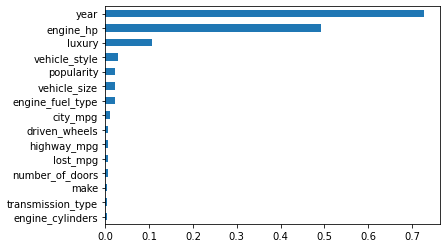

In [44]:
## Plot the above importances
importances['importances_mean'].sort_values().plot.barh()

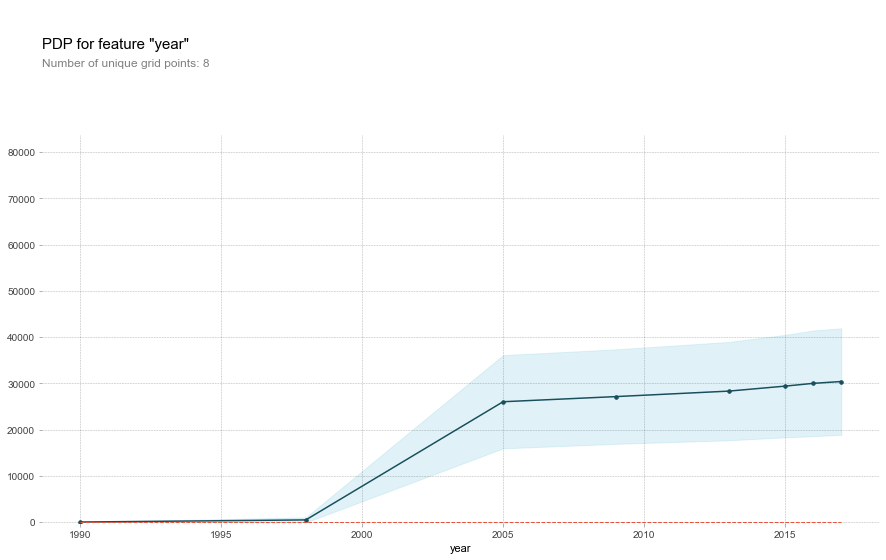

In [56]:
## Isolated partial dependence plot representing specific impact of 'year' on msrp predictions

isolate = pdp_isolate(gbr,
                     X_test,
                     X_test.columns,
                     feature='year')

pdp_plot(isolate, 'year');

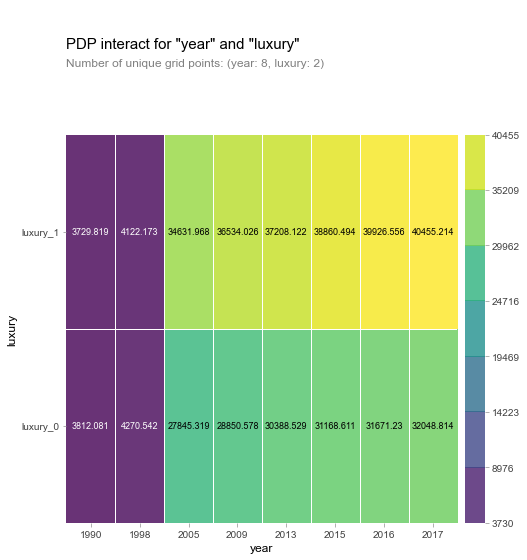

In [55]:
## PDP to see how luxury and year influence price predictions
## engine_hp has null values

interact = pdp_interact(gbr,
                       X_test,
                       X_test.columns,
                       ['year', 'luxury'])

pdp_interact_plot(interact, plot_type='grid', feature_names=['year', 'luxury']);